In [1]:
import pandas as pd
import segmentation_models_pytorch as smp
import pickle
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import segmentation_models_pytorch as smp

from sklearn.model_selection import KFold, StratifiedKFold
from functools import partial
from typing import List, Optional, Callable

import os
import logging
os.chdir('../../')

from src.utils.util import get_labedict
from src.utils.dataset import VOCDataset, VOC_ProbDataset
from src.utils.train import TrainEpoch, ValidEpoch
from src.utils.metrics import Multiclass_IoU_Dice
from src.utils.augmentation import get_training_augmentation, \
                                get_validation_augmentation, \
                                get_preaug, get_postaug, \
                                get_preprocessing
                                

In [2]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def get_logger():
    output_loc = os.path.join('./output')
    os.makedirs(output_loc, exist_ok=True)

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
    file_handler = logging.FileHandler(os.path.join(output_loc, 'train.log'))
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    return logger

def seed_all(seed):
    # https://discuss.pytorch.org/t/reproducibility-with-all-the-bells-and-whistles/81097
    if not seed:
        seed = 10
    print("[ Using Seed : ", seed, " ]")
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_vc_df(cur_train_df, col):
    cnt_vc = pd.DataFrame(cur_train_df[col].value_counts())
    cnt_vc = cnt_vc.reset_index()
    cnt_vc.columns = [col,'cnt']
    cnt_vc['weight'] = 1/np.log(cnt_vc.cnt)
    cnt_vc['weight'] = cnt_vc['weight'] / cnt_vc['weight'].sum()
    return cnt_vc

In [3]:
logger = get_logger()

# set seed
seed = 2022
seed_all(seed)

# load data
labeldict = get_labedict()
label2num = labeldict['label2num']
num2label = labeldict['num2label']

train_df = pd.read_csv('./data/train_df.csv', index_col=0)
kf_cols =  [i for i in train_df.columns if i.startswith('kf')]
skf_cols =  [i for i in train_df.columns if i.startswith('skf')]

cnt_df = pd.read_csv('./data/imbalance_df.csv', index_col=0)

upsample_dict = dict(cnt_df[cnt_df['after'] < 60]['after'].apply(lambda x: int(100/x) ))
upsample_list = []
for label, num in upsample_dict.items():
    upsample_list += [label]*num

# get congigs
LR = 0.1
IMBALANCE = True
SPLIT = 'random'
SPLIT_RS = 1
SPLIT_FNUM = 0
RESAMPLING_STRATEGY = 'x2'
AUG_STRATEGY = 1.0
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d' 
DEVICE = 'cuda'
VERBOSE = True
copy_paste_prob = None if AUG_STRATEGY == 'none' else AUG_STRATEGY
copy_paste_prob

if IMBALANCE:
    print(f'before imbalance {len(train_df)}')
    train_df = train_df[train_df['use_image']==True]
    print(f'after imbalance {len(train_df)}')

cur_split = f'{SPLIT}_rstate{SPLIT_RS}_fold{SPLIT_FNUM}'
cur_train_df = train_df[train_df[cur_split] == 'train']
cur_val_df = train_df[train_df[cur_split] == 'val']

if RESAMPLING_STRATEGY == 'x2':
    vc_col = None
    vc_df = None
elif RESAMPLING_STRATEGY == 'cluster':
    vc_col = 'cluster_num_16'
    vc_df = get_vc_df(cur_train_df, vc_col)
elif RESAMPLING_STRATEGY == 'cnt':
    vc_col = 'major_label'
    vc_df = get_vc_df(cur_train_df, vc_col)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)



[ Using Seed :  2022  ]
before imbalance 1464
after imbalance 993


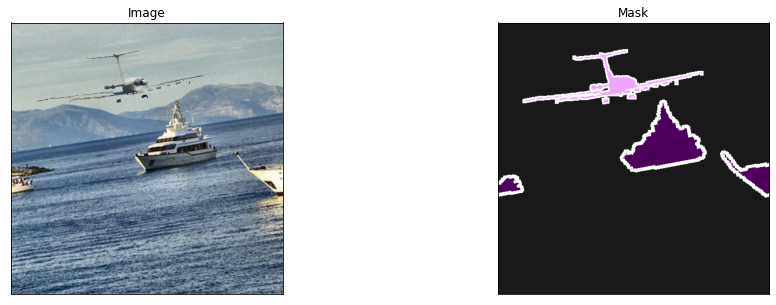

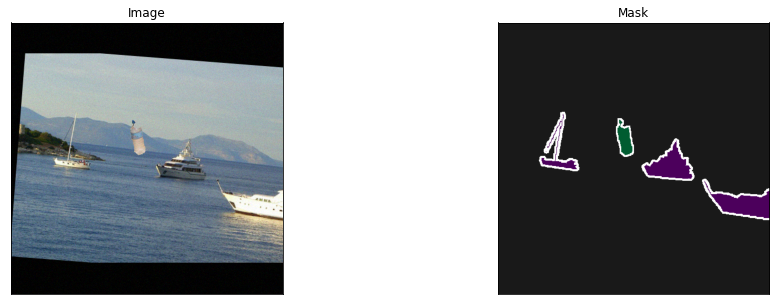

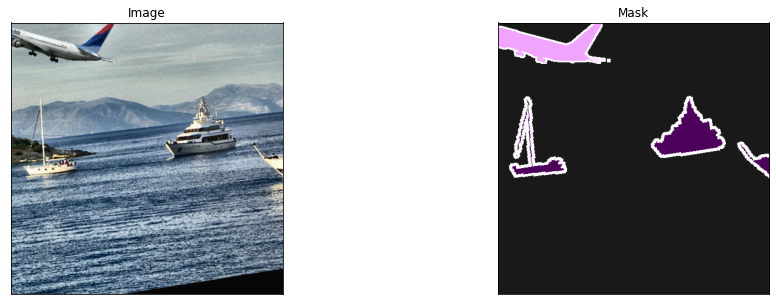

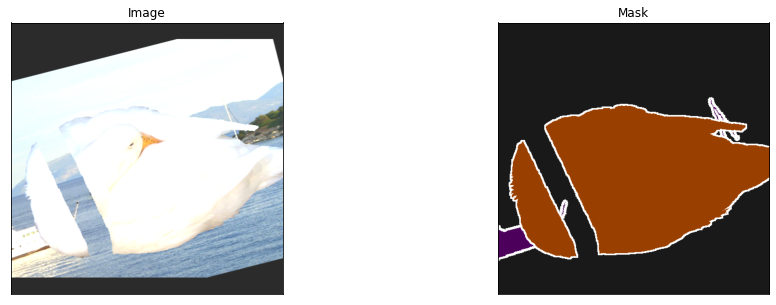

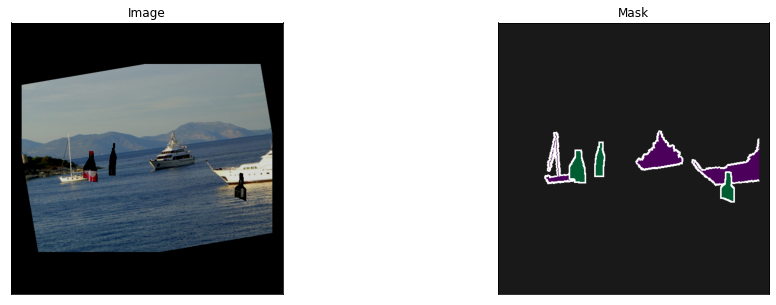

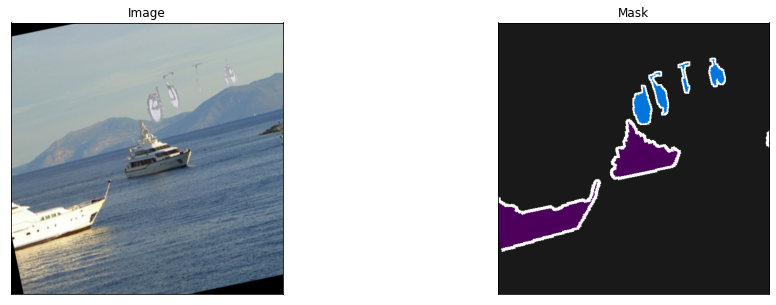

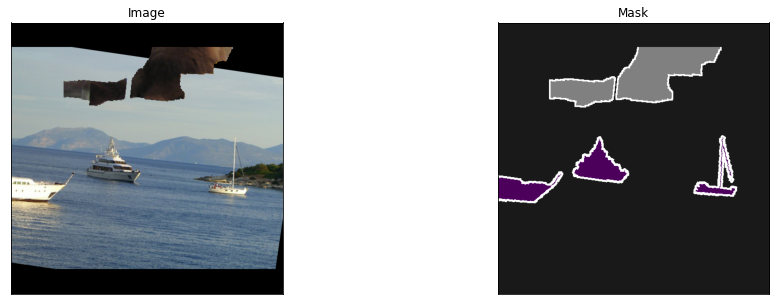

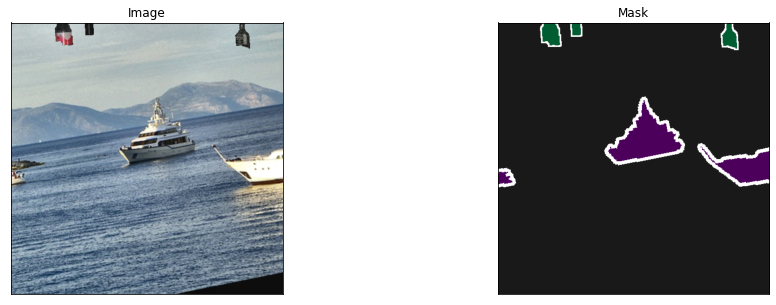

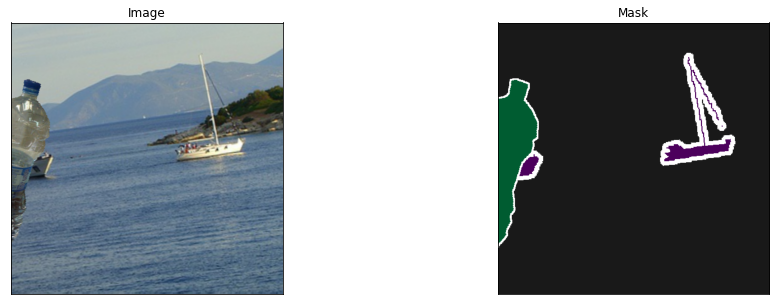

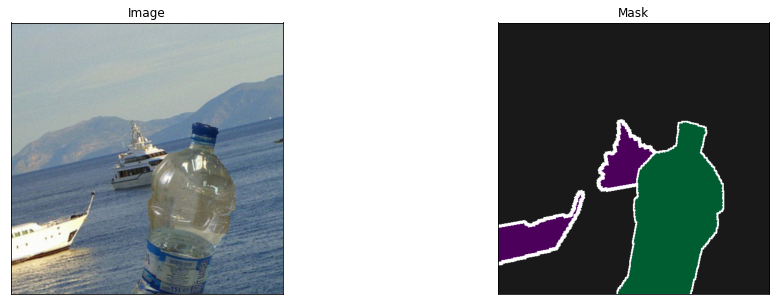

In [16]:
from torch.utils.data import ConcatDataset
from src.utils.util import color_mask, get_num2color
from src.utils.util import visualize

num2color = get_num2color(num2label)

dataset_a = VOC_ProbDataset(cur_train_df,
                            augmentation=get_training_augmentation(),
                            #preprocessing=get_preprocessing(preprocessing_fn),
                            copypaste_prop = 1,
                            upsample_list=upsample_list,
                            pre_aug=get_preaug,
                            post_aug=get_postaug(),
                            label2num=label2num,)

dataset_b = VOC_ProbDataset(cur_train_df,
                            augmentation=get_training_augmentation(),
                            #preprocessing=get_preprocessing(preprocessing_fn),
                            copypaste_prop = 1,
                            upsample_list=upsample_list,
                            pre_aug=get_preaug,
                            post_aug=get_postaug(),
                            label2num=label2num,
                            vc_col=vc_col,
                            vc_df=vc_df)

train_dataset = ConcatDataset([dataset_a, dataset_b])

valid_dataset = VOCDataset(
    cur_val_df,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

# same image with different random transforms
for i in range(10):
    image, mask, _ = train_dataset[3]
    visualize(num2color, image=image, mask=mask)
    

In [18]:
dataset_a = VOC_ProbDataset(cur_train_df,
                            augmentation=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn),
                            copypaste_prop = 1,
                            upsample_list=upsample_list,
                            pre_aug=get_preaug,
                            post_aug=get_postaug(),
                            label2num=label2num,)

dataset_b = VOC_ProbDataset(cur_train_df,
                            augmentation=get_training_augmentation(),
                            preprocessing=get_preprocessing(preprocessing_fn),
                            copypaste_prop = 1,
                            upsample_list=upsample_list,
                            pre_aug=get_preaug,
                            post_aug=get_postaug(),
                            label2num=label2num,
                            vc_col=vc_col,
                            vc_df=vc_df)

train_dataset = ConcatDataset([dataset_a, dataset_b])

valid_dataset = VOCDataset(
    cur_val_df,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0,
                        worker_init_fn= seed_worker)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

label_names = label2num.keys()

weight_decay = 1e-4

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(label_names), 
    activation=ACTIVATION,
)

classes_of_interest = [label2num[k] for k in label2num.keys() \
                    if k not in ['border']] 

loss = smp.losses.DiceLoss(mode = 'multiclass', 
                           from_logits = False,
                           ignore_index = label2num['border'])
setattr(loss, '__name__', 'dice_loss')

metrics = [
    Multiclass_IoU_Dice(mean_score=True,
                        nan_score_on_empty=True,
                        classes_of_interest = classes_of_interest,
                        name='multiclass_iou')
]

# optimizer = torch.optim.Adam([ 
#     dict(params=model.parameters(), lr=0.01),
# ])
optimizer = torch.optim.SGD(params=[
        {'params': model.encoder.parameters(), 'lr': 0.1 * LR},
        {'params': model.decoder.parameters(), 'lr': LR},
        {'params': model.segmentation_head.parameters(), 'lr': LR},
    ], lr=LR, momentum=0.9, weight_decay=weight_decay)

train_epoch = TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=VERBOSE,
)

valid_epoch = ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=VERBOSE,
)

scheduler = ReduceLROnPlateau(optimizer, 'max', patience=7)

max_score = 0

logger.info('Train Started')
for i in range(1, 201): 
    logger.info('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    logger.info(f"train dice loss:{train_logs['dice_loss']:.4f}, train iou:{train_logs['multiclass_iou']:.4f}")
    valid_logs = valid_epoch.run(valid_loader)
    logger.info(f"valid dice loss:{valid_logs['dice_loss']:.4f}, valid iou:{valid_logs['multiclass_iou']:.3f}")

    if (max_score < valid_logs['multiclass_iou']) and (i > 60):
        max_score = valid_logs['multiclass_iou']
        torch.save(model, './best_model.pth')
        logger.info('Model saved!')
    scheduler.step(valid_logs['multiclass_iou'])
    

2022-06-12 22:38:30,873 - root - INFO - Train Started
2022-06-12 22:38:30,874 - root - INFO - 
Epoch: 1


train:  10%|▉         | 19/196 [00:17<02:41,  1.09it/s, dice_loss - 0.5437, multiclass_iou - 0.08542]


KeyboardInterrupt: 

- Todo
    - test는 마치면 바로 테스트 할 수 있도록 변경 
    - confusion matrix & metrics on classes
    - save with state_dict


- Epoch 설정
    - https://github.com/VainF/DeepLabV3Plus-Pytorch/blob/master/main.py
    - (batch_size * total_itrs) / len(train_df) = num_epoch
    - 30000 * 16 / 1464 = 327.8688524590164
    

In [21]:
test_df = pd.read_csv('./data/test_df.csv', index_col=0)
best_model = torch.load('./best_model.pth')

In [22]:
test_dataset = VOCDataset(
    test_df,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)
test_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

test_epoch = ValidEpoch(
    best_model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

test_log = test_epoch.run(test_loader)



valid:  49%|████▉     | 104/211 [00:03<00:03, 29.11it/s, dice_loss - 0.01783, multiclass_iou - 0.751]


KeyboardInterrupt: 